In [172]:
#Import the Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

import plotly.express as px
import joblib 

import warnings
warnings.filterwarnings('ignore')

In [99]:
#Lets load the data
data = pd.read_csv('Country-data.csv')
data.head(2)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [101]:
#Do we have any Null values ?
data.isnull().values.any()

False

In [102]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


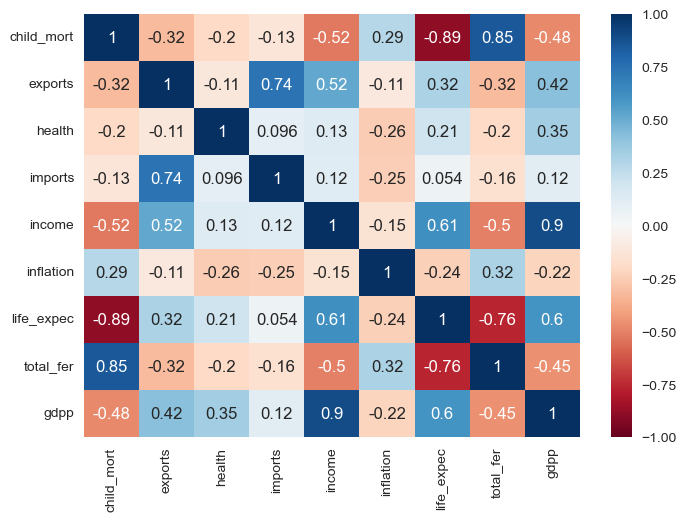

In [103]:
# Correlation Heatmap
sns.heatmap(data.corr(numeric_only=True),annot=True,cmap='RdBu',vmin=-1,vmax=1)
plt.show()

Inference 
1. gdpp and income have high correlation of 0.9.
2. life_expec and child_mort have negative correlation of -0.89.
3. total_fer  and child_mort have high correlatio of 0.85 . 
4. imports and expoets also have god relation of 0.74 .
5. gdpp and child_mort have high negative correlation of -0.48.
6. exports and income have mild correlation of 0.52.

## Visualize the Data

In [104]:
#Before we begin visalization lets convert counry to index(As its a reduandant columns)
data.set_index('country',inplace=True)

In [105]:
data.head(2)


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


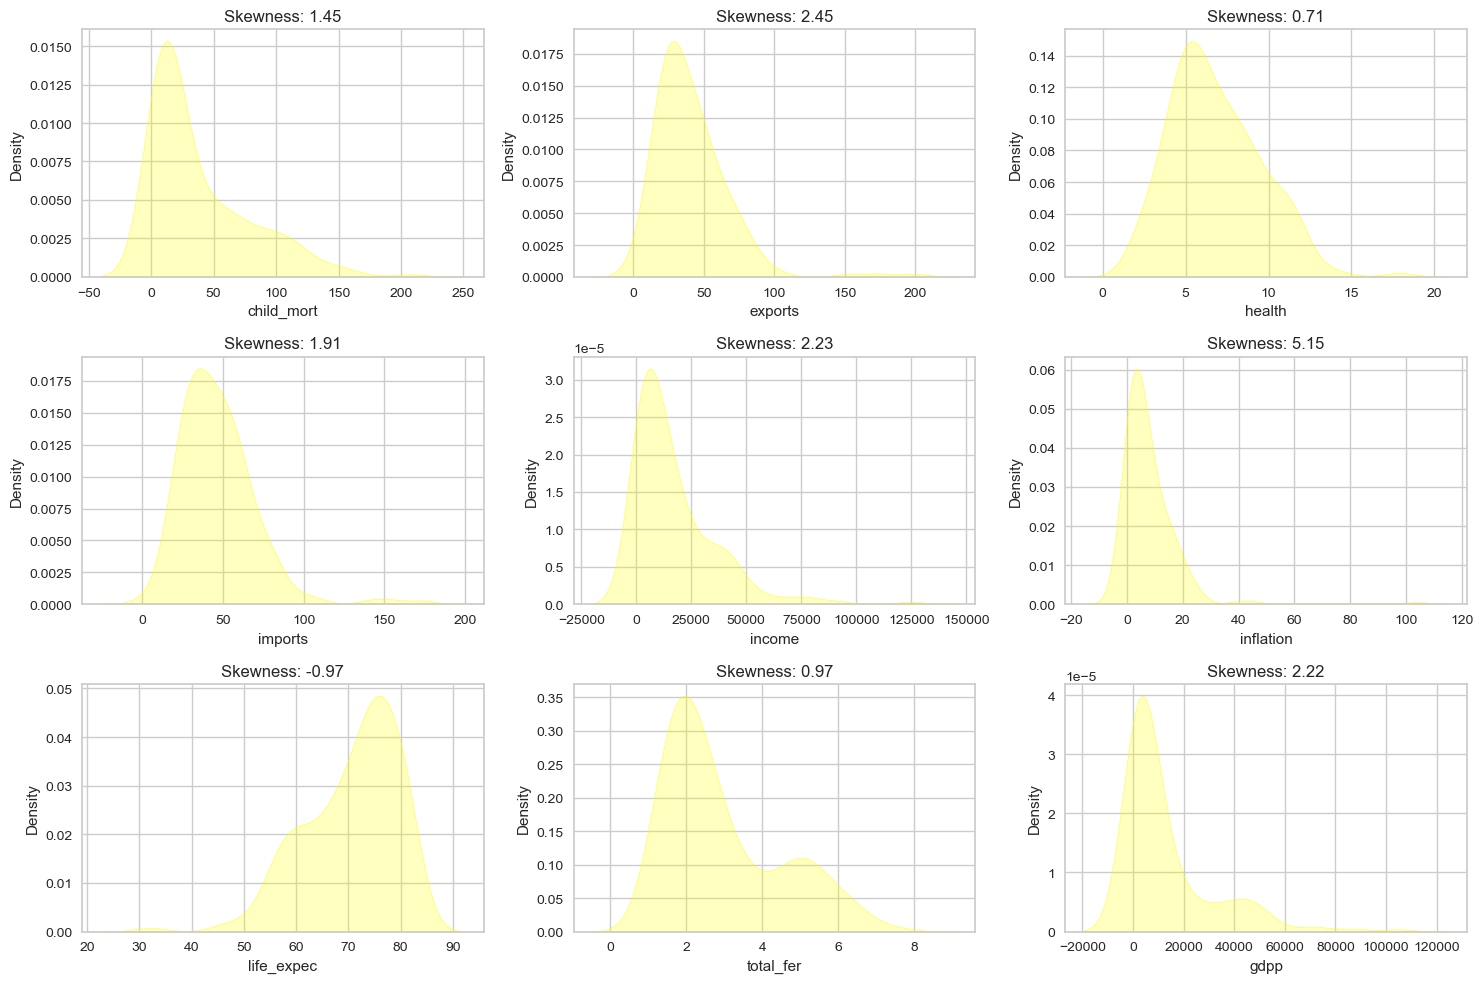

In [106]:
## Univariate Analysis
plt.figure(figsize=(15,10))
t= 1 
for i in data.columns:
    plt.subplot(3,3,t)
    sns.kdeplot(data=data,x=i,fill=True,color='yellow')
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()
    

Inference - all the features are right skewed with max skewness of 5.15 .

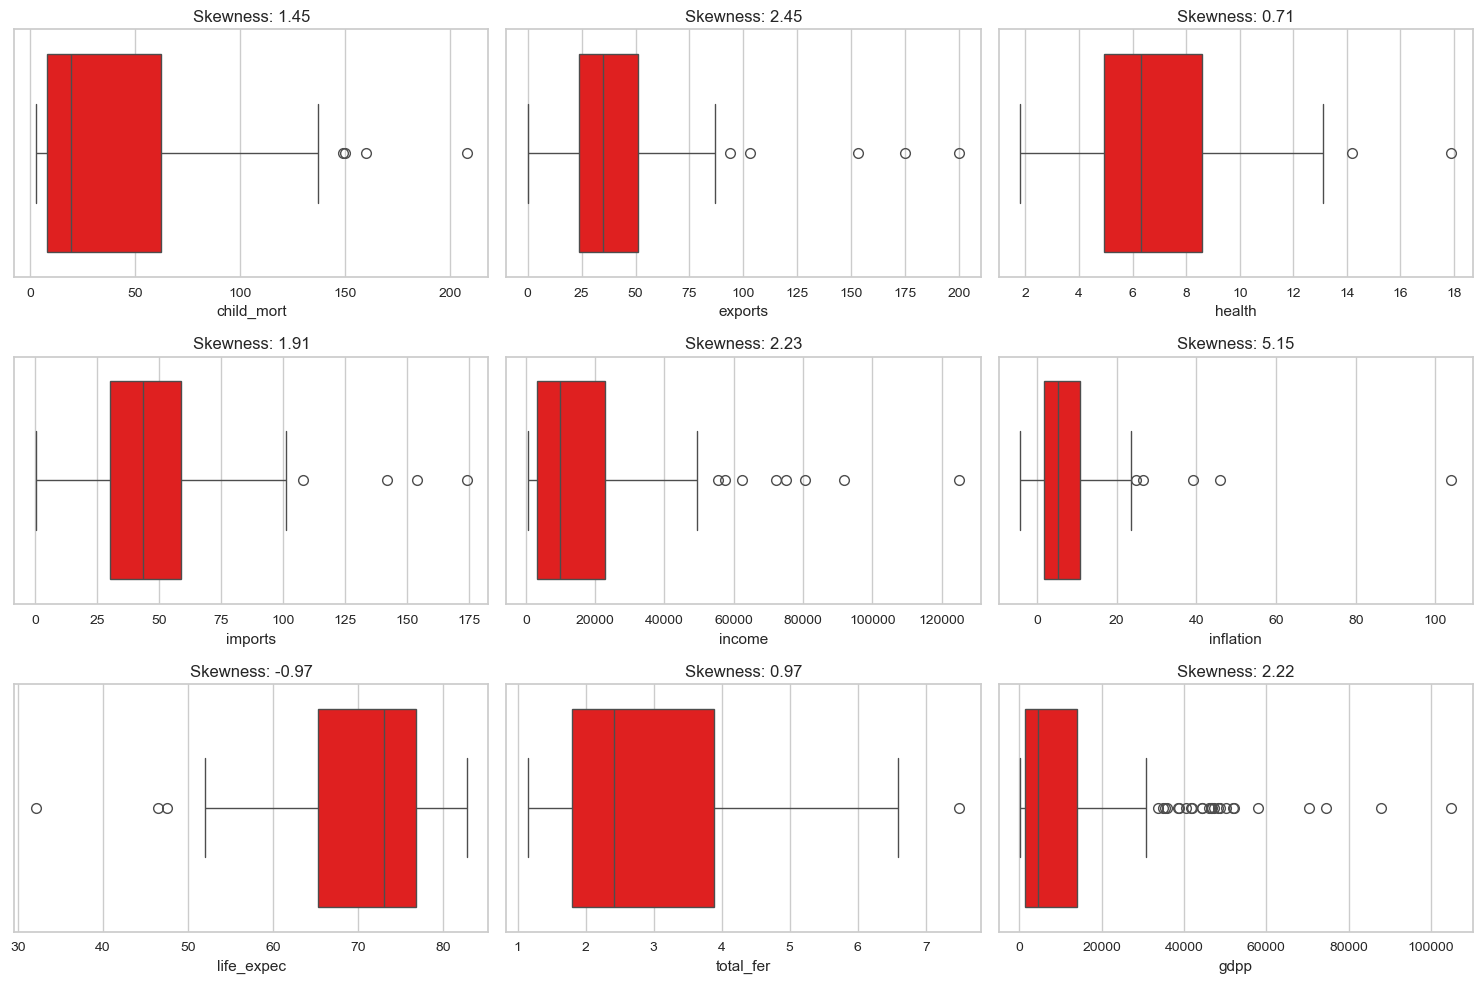

In [107]:
#For Outliers 
plt.figure(figsize=(15,10))
t= 1 
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,fill=True,color='red')
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

In [108]:
#There are some outliers in some features

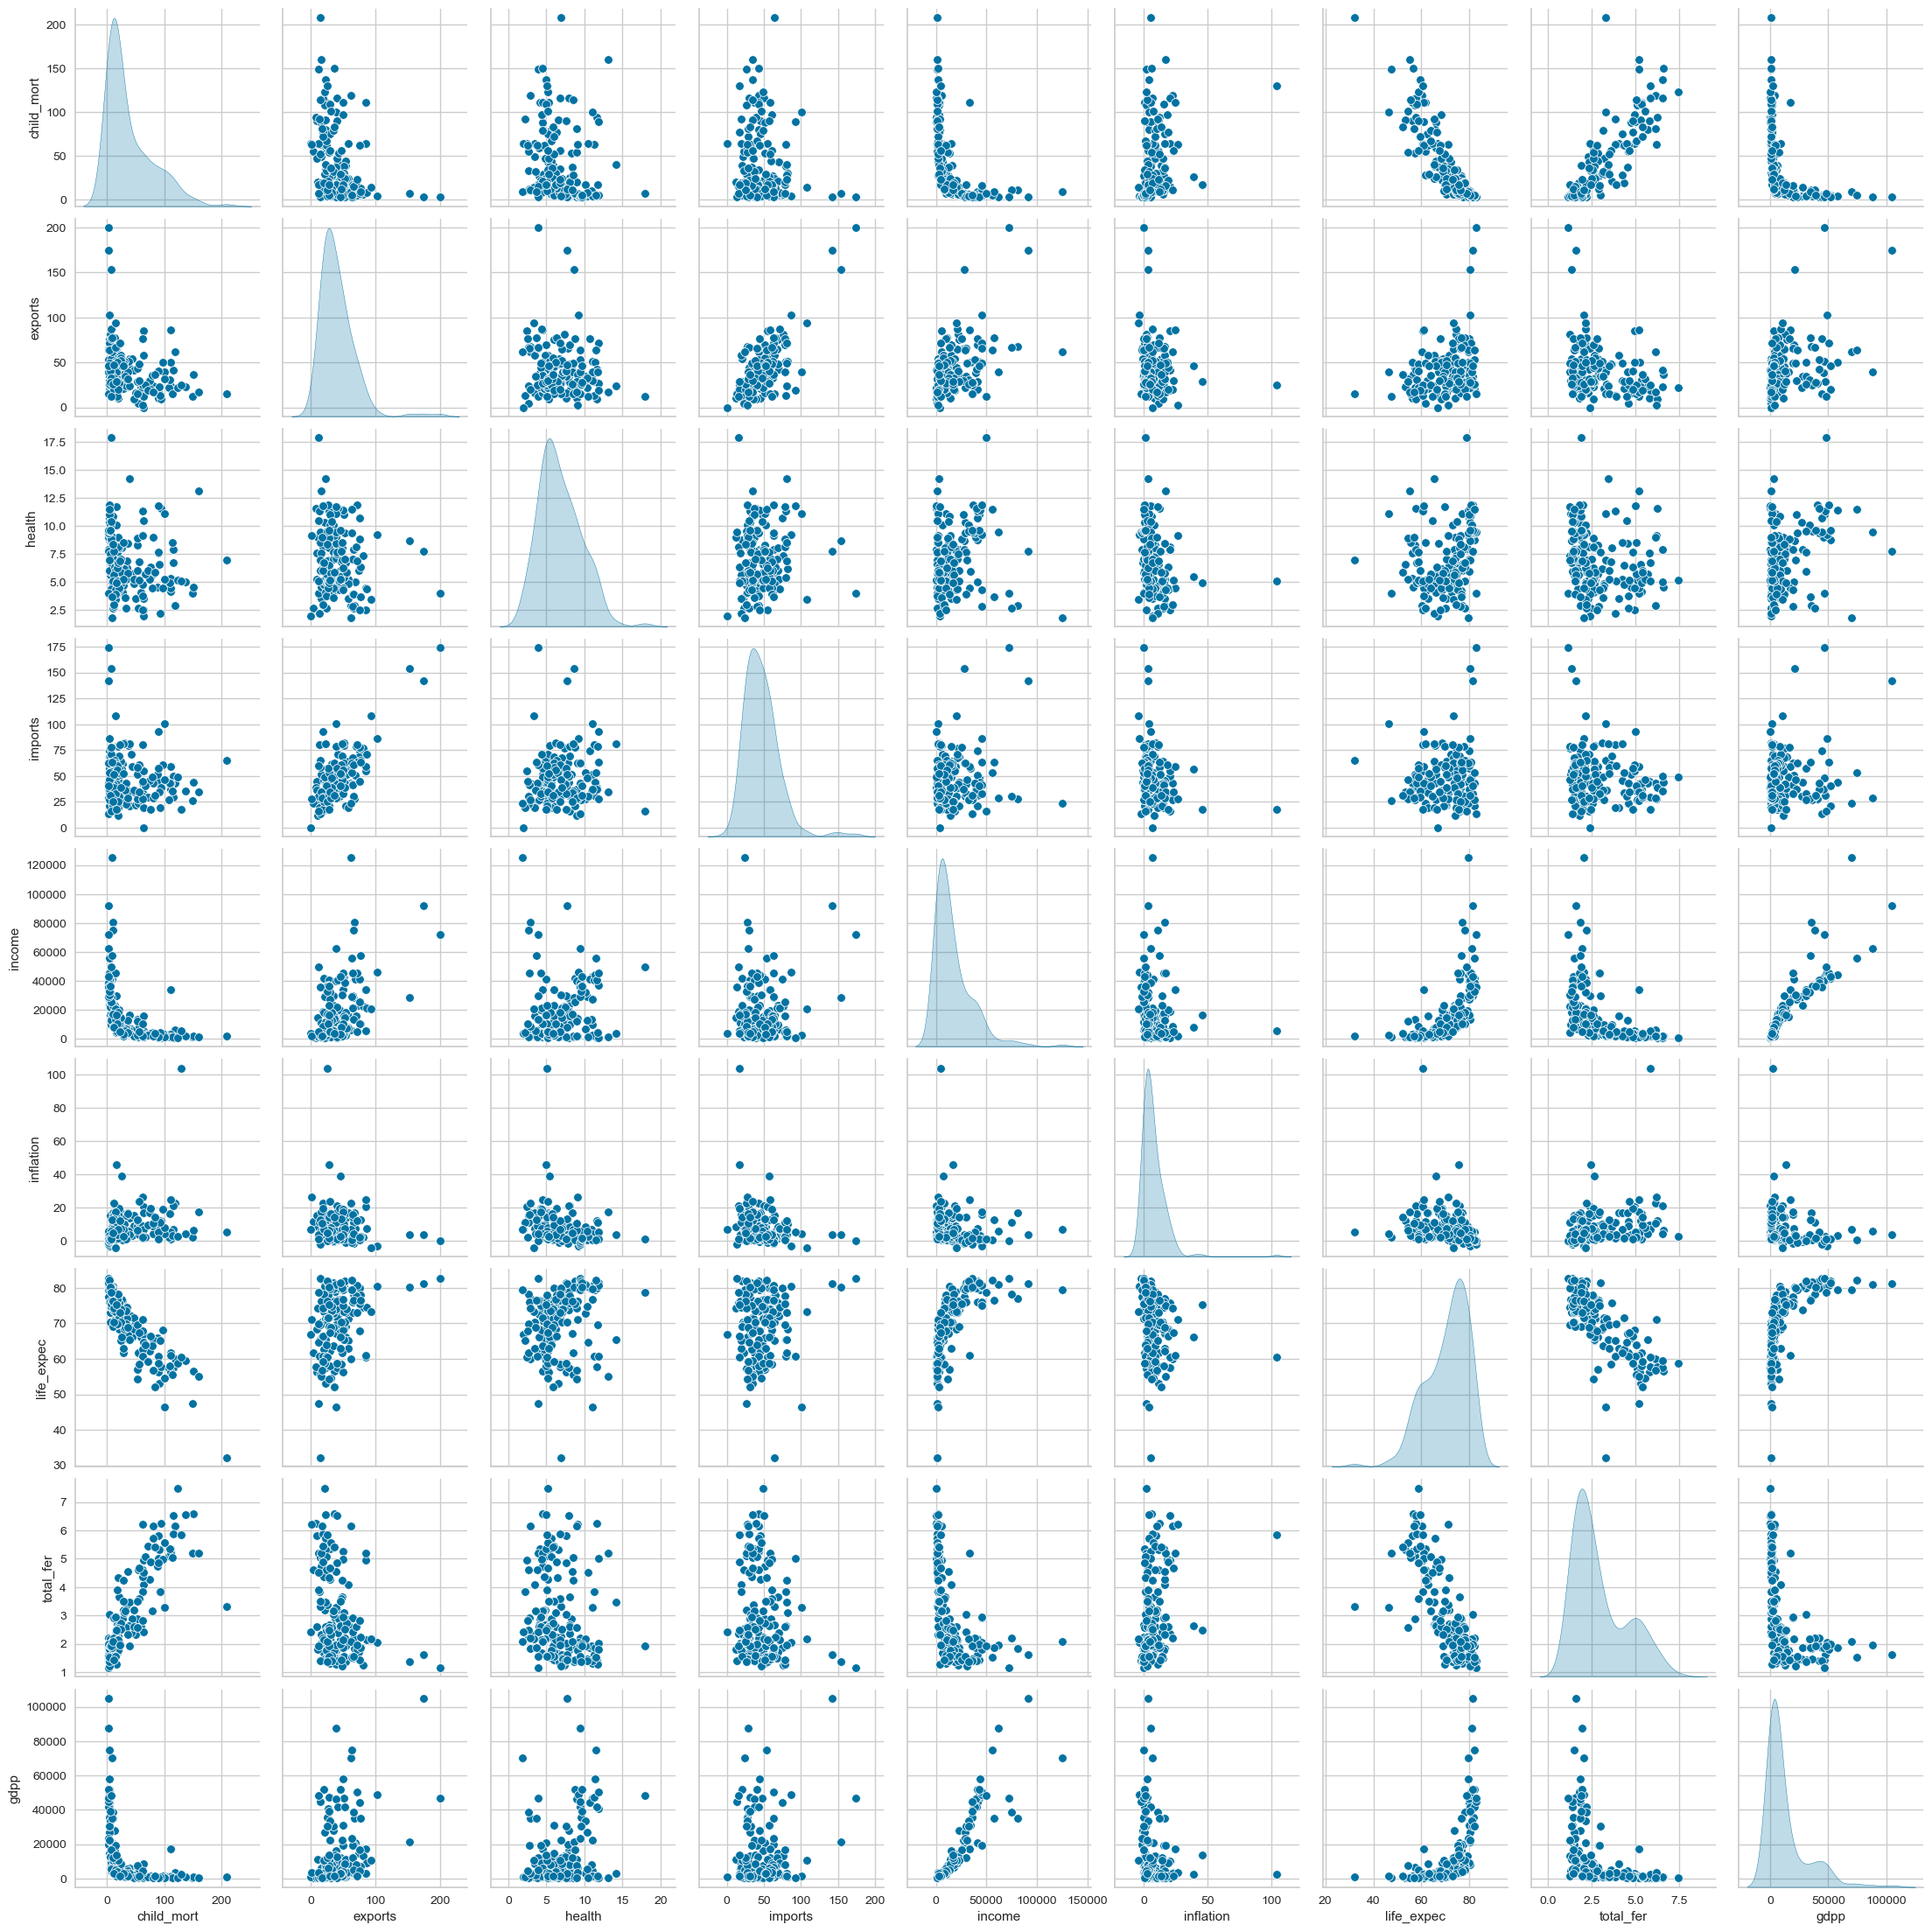

In [109]:
#Multi-varataite analysis
sns.pairplot(data,diag_kind='kde')
plt.show()

In [110]:
#Multivaraiate is for trends visiualaztion

## Data Preprocessing

In [111]:
#check for missing values
data.isnull().sum().sum()
#No missing values

0

In [112]:
#Lets treatwith expteme outliers
#Lets go with caping using IQR Method
#In order to cap only the extrme ones lest keep whisker length = 2.5 

for i in data.columns:
    q1,q3 = np.quantile(data[i],[0.25,0.75])
    iqr = q3-q1
    ul = q3 + 2.5*iqr
    ll = q1 - 2.5*iqr 
    data[i] = data[i].apply(lambda x: ul if x>ul else ll if x<ll else x) 

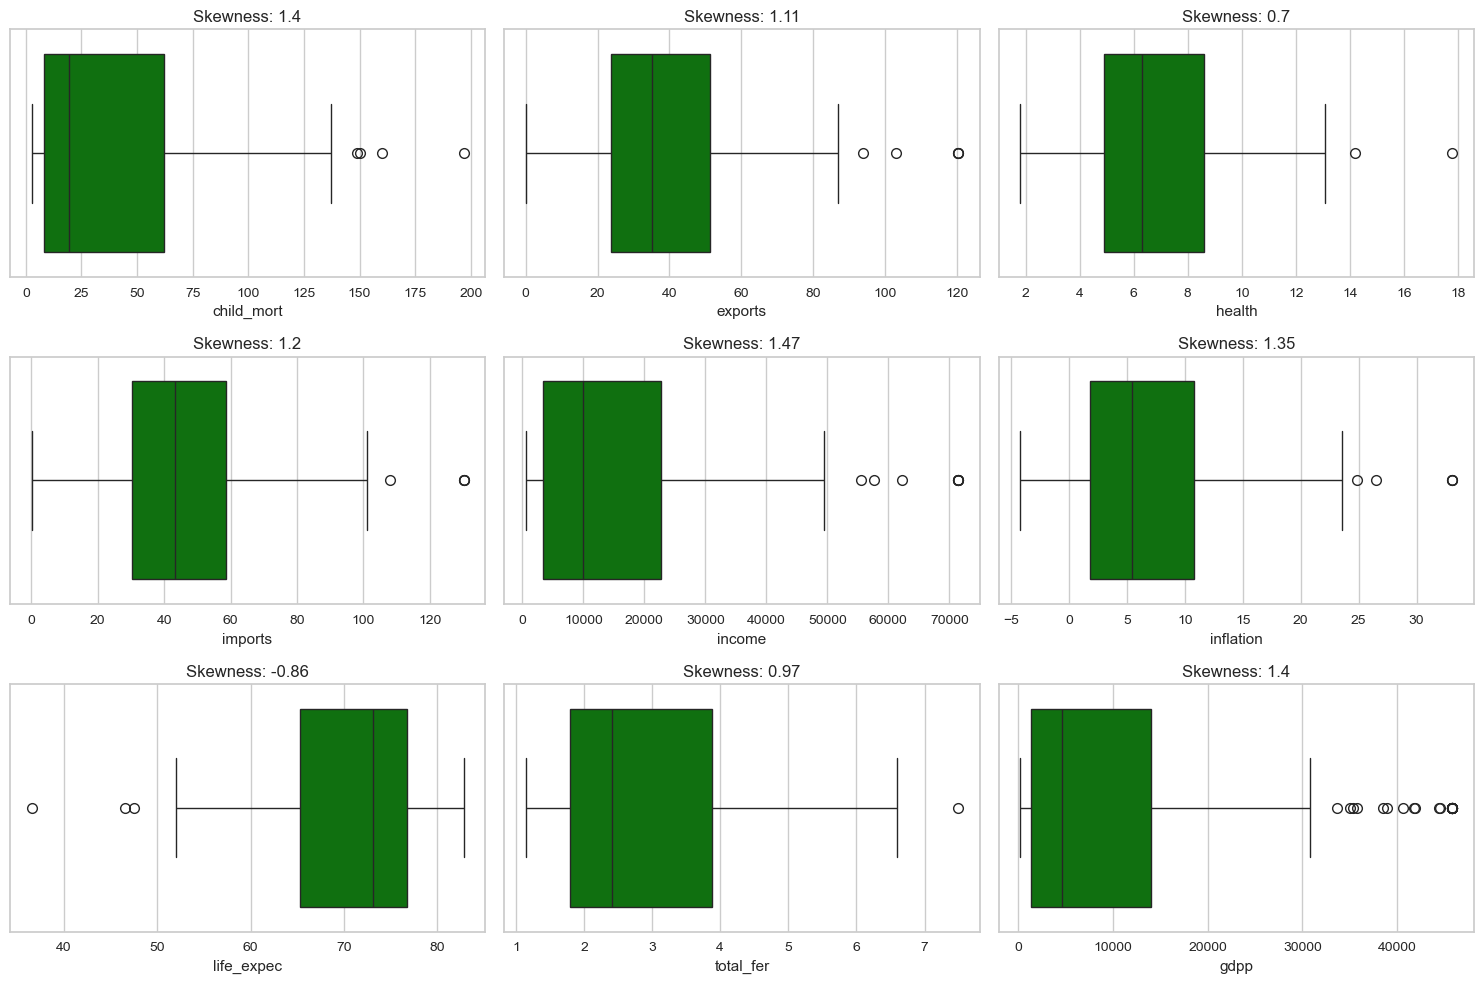

In [113]:
#Lets how have been the outlier treated  
#For Checing of Outliers 
plt.figure(figsize=(15,10))
t= 1 
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,fill=True,color='green')
    plt.title(f'Skewness: {round(data[i].skew(),2)}')
    t+=1
plt.tight_layout()
plt.show()

Extrme outliers of features are treated . 

In [114]:
#Lets apply PCA on the dat before we procced with clustering.
#Just to hvae better visualization and better clustering .

#Lets import the Libaries for PCA.

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


In [116]:
#In PCA we have to Standaraied the data.
scaler = StandardScaler()

#Also lets create an instances for PCA
pca = PCA(n_components=9,random_state=7)

#Lets create pipeline for the above two prcoess
pipeline = Pipeline([('Scale',scaler), ('PCA',pca)])

In [117]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=7))])

In [118]:
#This helps us what % of data we should take 
pca.explained_variance_ratio_.cumsum()
#taking 5 feature as they are explinaing 95% approx varaince

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697,
       0.96981892, 0.98571825, 0.99510744, 1.        ])

In [119]:
#Re-Fitting the pipeline

scaler = StandardScaler()

#Also lets create an instances for PCA
pca = PCA(n_components=5,random_state=7)

#Lets create pipeline for the above two prcoess
pipeline = Pipeline([('Scale',scaler), ('PCA',pca)])

#Hence 9 Dimensioal data is reduced it to 5 .

In [131]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=7))])

In [132]:
final_data = pipeline.transform(data)

In [133]:
# Tranform return s the array let convert to dataframe
final_data = pd.DataFrame(final_data,columns=['PC1','PC2','PC3','PC4','PC5']
                          ,index=data.index)
final_data.head(5)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119
Angola,-3.150063,1.425283,-1.784982,1.580071,0.142609
Antigua and Barbuda,1.145313,0.392985,0.151332,-0.823193,-0.370311


## K-Means Clustering

In [123]:
#Importing the Libaries
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

In [124]:
#Indenity the value of k

#KElbow Visualizer
kelbow = KElbowVisualizer(estimator=KMeans(random_state=8),k=10)

In [134]:
kelbow.fit(final_data)

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=10, random_state=8))

Inference :
Although the above plot shows and marks the Elbow at = 6 . But we can see as significant drop  in the distrotion score at k = 2 and k = 3 .
As we increse the number of cluster it might became over fitted . 
lets explore SilhouetteVisualizer for more generailies value of K. 

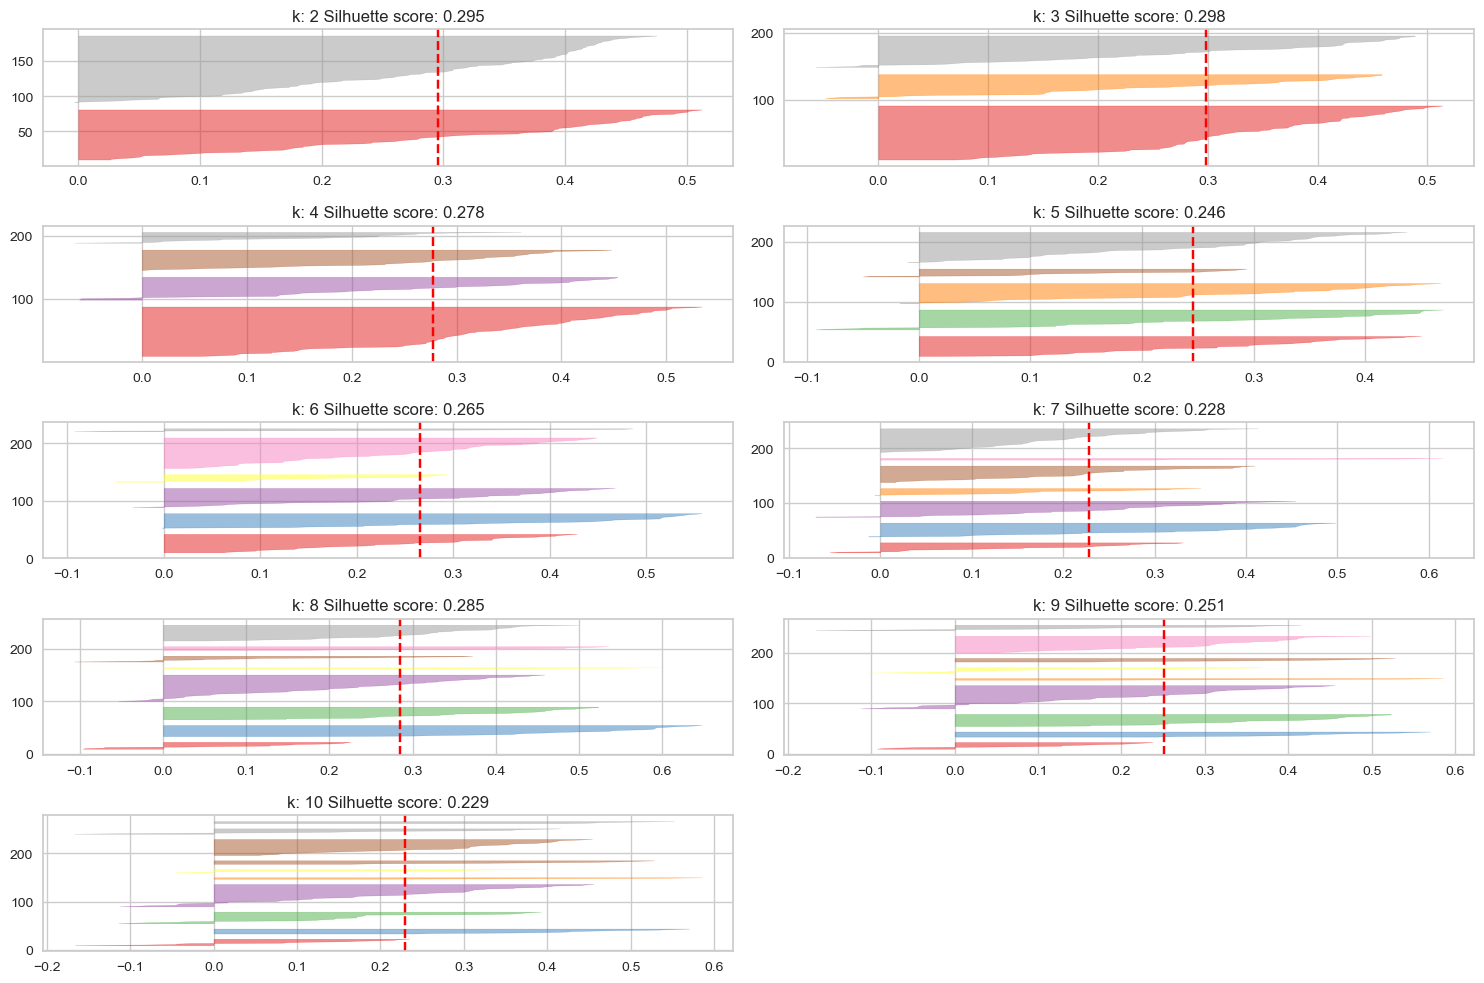

In [135]:
#Lets make the SihouetteVisualizer 
t=1
plt.figure(figsize=(15,10))
for i in range(2,11):
    plt.subplot(5,2,t)
    model = KMeans(n_clusters=i,random_state=2)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(final_data)
    plt.title(f'k: {i} Silhuette score: {round(sil_viz.silhouette_score_,3)}')
    t+=1
plt.tight_layout()
plt.show()

Inference :
After analysis Elbow plot and Silhouttles Visualizews lets with k=3.
Although there are few datapoints that have been missclassfiied but we see no drop in sillhoultes score and there is good enough data is every cluster.
Also form k-elbow plot significant drop in WCSS(Distrotion score) was obsereved from k=2 to k=3.

In [130]:
final_kmeans = KMeans(n_clusters=3,random_state=14)

In [136]:
labels = final_kmeans.fit_predict(final_data)

In [137]:
#lets check the Silhouette Score
print('Silhouette Score',silhouette_score(final_data,labels))

Silhouette Score 0.29845782348296623


In [140]:
#Lets put these labels on PCA data
final_data['Labels'] = labels
final_data.head()

,PC1,PC2,PC3,PC4,PC5,labels,Labels
country,,,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800,1,1
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623,0,0
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119,0,0
Angola,-3.150063,1.425283,-1.784982,1.580071,0.142609,1,1
Antigua and Barbuda,1.145313,0.392985,0.151332,-0.823193,-0.370311,0,0


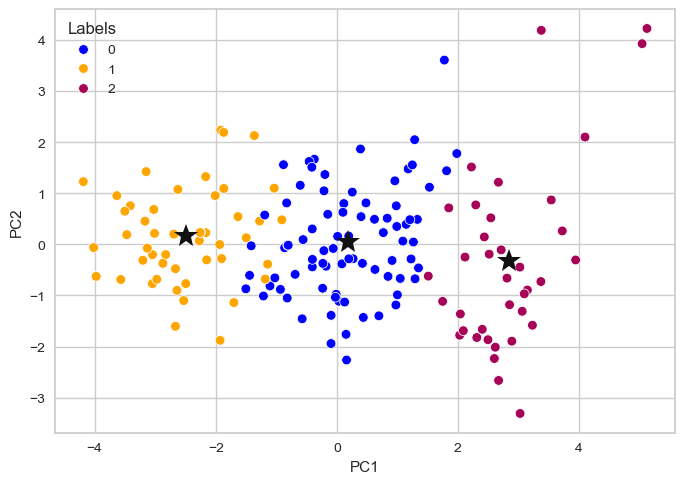

In [146]:
# Lets Visaualize the cluster
# In order to get the best visualization lets choose PC1 and PC2 as they have Maximum Variance

centroids = final_kmeans.cluster_centers_
centroids

sns.scatterplot(data=final_data,x='PC1',y='PC2',hue='Labels',palette=['blue','orange','m'],)
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms=18,color='k')
plt.show()

In [147]:
#To have bussiness intercpretation lets put the labels on orginal dataset
data['Label'] =labels
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,1
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0


In [148]:
data.groupby(by='Label').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Label,,,,,,,,,
0,21.508537,40.797317,6.231951,48.097561,12281.097561,7.474744,72.875610,2.311707,6291.146341
1,92.131771,28.546229,6.296458,41.443040,3937.770833,10.438854,59.438542,4.953958,1902.916667
2,5.237838,53.575000,8.780270,49.129054,42690.878378,2.588432,79.956757,1.755676,36905.405405


Inference:
 After studing the above data , we can conclude that countries that have been assigned in cluster 1 can be callled underdeveloped, while cluster 2 are develpoed.
 Countries beloning to cluster 0 are doing avg in most of the factors but struggling in some economic factores like GDPP/ Income and expenditure on health.
 Hence they acn be called develpoing .

In [149]:
data['Label'] = data['Label'].map({0:'Developing',1:'UnderDeveloping',2:'Develpoed'})

In [151]:
#Develpoed Countries
data[data['Label'] == 'Develpoed'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')

In [152]:
#Develpoing Countries
data[data['Label'] == 'Developing'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
       'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles',
       'Solomon Islands', 'Sri Lanka', 'St. Vincent and the Grenadines',
       'Suriname', 'Tajikistan', '

In [153]:
#UnderDevelpoing Countries
data[data['Label'] == 'UnderDeveloping'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
       'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype='object', name='country')

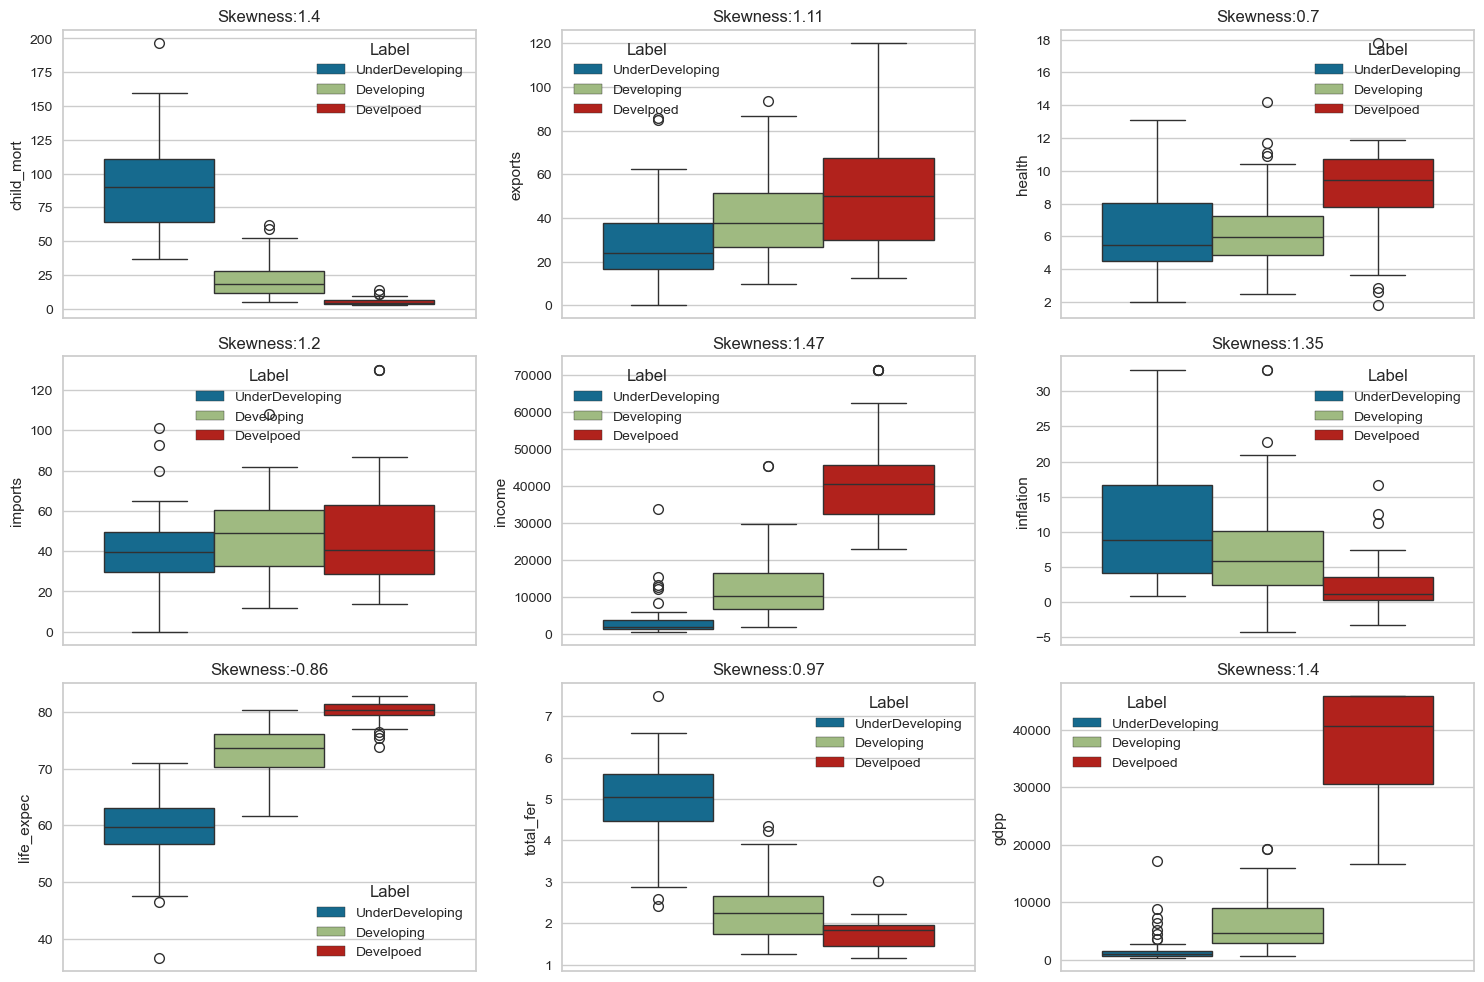

In [160]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    if i != 'Label':   
        plt.subplot(3,3,t)
        sns.boxplot(data=data,y=i,hue='Label',palette=['b','g','r'])
        plt.title(f'Skewness:{round(data[i].skew(),2)}')
        t+=1
        
plt.tight_layout()
plt.show()

In [162]:
#World Map
px.choropleth(data_frame=data,locationmode='country names',locations=data.index , color='Label',
              color_discrete_map={'UnderDeveloping':'red','Develpoing':'blue','Develpoed':'green'})

## Deployment

In [170]:
#Expect labels that is the last feature , we are slicing 
input_data = data.iloc[0,:-1].values
input_data

array([90.2, 10.0, 7.58, 44.9, 1610.0, 9.44, 56.2, 5.82, 553.0],
      dtype=object)

In [171]:
#We are transforming thethe sliced data
final_input_data =  pipeline.transform([input_data])
final_input_data

array([[-3.04363665, -0.20115529,  0.95132235,  0.79344472, -0.00680001]])

In [169]:
final_kmeans.predict(final_input_data)[0]

1

In [173]:
#Lets create a joblb file of pipeline
with open('pipeline.joblib','wb') as file:
    joblib.dump(pipeline,file)

In [174]:
#Lets create a joblb file of model
with open('model.joblib','wb') as file:
    joblib.dump(final_kmeans,file)